In [142]:
import pickle
import os
import numpy as np
import mdtraj
import deeptime
import glob
import matplotlib.pyplot as plt
import subprocess

In [143]:
from westpa_helpers import *

In [144]:
# select trace iteration and segment
iteration = 41
segment = 1079

In [145]:
# Define any additional coordinate files, such as the ground truth
# 0 will be red outline
# 1 will be density map (eventually msm)
coordinate_files = [
    "/media/DATA_14_TB/daniel_s/cg_all_benchmark_finetuneE01_s4/trpcage*/raw/coordinates.npy",
]

In [146]:
def get_trace_trajectory(topology, iteration, segment):
    traj_dirs = []
    traj_id = str(iteration) + ":" + str(segment)
    subprocess.run(["/home/md-ml/miniconda3/envs/andy-reports-3/bin/w_trace", traj_id])
    
    input_fname = f"traj_{iteration}_{segment}_trace.txt"

    # Collect all trajectory segments that create full trajectory
    lines = [
        l for l in open(
            input_fname,
            "r",
            encoding="utf-8").readlines() if not l.startswith("#")]
    segs = []
    for l in lines:
        iter, seg = map(int, l.split()[:2])
        seg = "%06d" % seg
        iter = "%06d" % iter
        segs.append((iter, seg))
    paths = [
        f"traj_segs/{it_str}/{seg_str}/seg.npz" for (it_str, seg_str) in segs]
    traj_list = []
    for i in range(1, len(segs)):
        data = np.load(paths[i])
        pos = data["pos"]*0.1  # shape: (n_frames, n_atoms, 3) + convert to nm
        traj = mdtraj.Trajectory(xyz=pos, topology=topology)
        traj_list.append(traj)

    full_traj = mdtraj.join(traj_list)

    return full_traj

In [147]:
# Change this to the root of the run
home_path="/media/DATA_18_TB_1/awaghili/WESTPA_CG/harmonic_mix_trpcage_2d_mabbin/westpa_prop"
os.chdir(home_path)

sim_config = extract_simulation_config()

# Will be needed to unpickle the TICA models
import sys
sys.path.append(sim_config['cgschnet_path'])

In [148]:
topology = convert_to_mdtraj_topology(create_cg_topology_from_all_atom(sim_config))

In [149]:
trace_traj = get_trace_trajectory(topology, iteration, segment)
traj_components = [calculate_component_values(load_tica_model(sim_config["tica_model_path"]), c, components_to_calculate) for c in trace_traj]
traj_components = np.array([[point[0][0], point[1][0]] for point in traj_components])


In [150]:
coordinate_list, label_list = load_trajectories(coordinate_files, size_limit=1000000)

In [151]:
components_to_calculate = range(2) # Number of components to calculate
tica_plot_pad = 0.2

kB = 0.0019872041 # kcal/mol/Kelvin
Temp = 300 # Kelvin

In [152]:
component_values = [calculate_component_values(load_tica_model(sim_config["tica_model_path"]), c, components_to_calculate) for c in coordinate_list]
component_values[0].keys(), [[len(v) for v in c.values()] for c in component_values]

component_maxs = [max([max(c[tica_comp]) for c in component_values]) for tica_comp in components_to_calculate]
component_mins = [min([min(c[tica_comp]) for c in component_values]) for tica_comp in components_to_calculate]
component_range = [*zip(component_mins, component_maxs)]

In [153]:
histogram_range = np.array([[component_range[0][0] - tica_plot_pad, component_range[0][1] + tica_plot_pad],
                            [component_range[1][0] - tica_plot_pad, component_range[1][1] + tica_plot_pad]])
num_contour_levels = 6

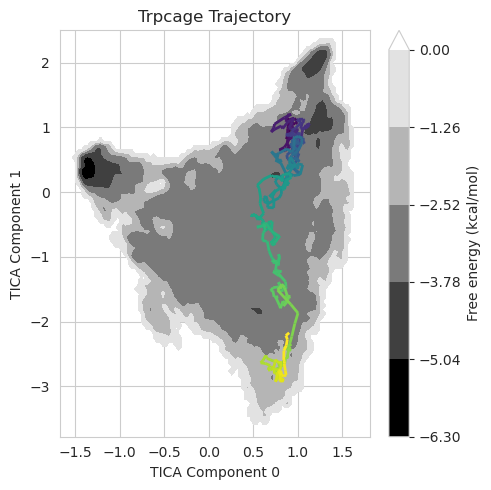

In [154]:
from matplotlib.collections import LineCollection


fig, ax = plt.subplots(figsize=(5, 5))

# Compute 2D histogram for the first component pair
hist2d, xedges, yedges = np.histogram2d(
    component_values[0][0],
    component_values[0][1],
    bins=(100, 100),
    range=histogram_range,
)

hist_log_mask = hist2d > 0
hist2d[hist_log_mask] = -kB * Temp * np.log(hist2d[hist2d > 0])
hist2d[~hist_log_mask] = 0.0000001 # The histograms look nicer if the undefined values are slightly more than zero

# Define contour levels
levels = np.linspace(round(np.min(hist2d) * 1.1, 1), 0, num_contour_levels)

# Plot filled contour
contour = ax.contourf(
    hist2d.T,
    origin='lower',
    extent=histogram_range.flatten(),
    levels=levels,
    extend='max',
#     colors=[plt.cm.winter_r(i / (len(levels) - 1)) for i in range(len(levels) - 1)] + [(0.0, 0.0, 0.0, 0.0)]
    colors = [plt.cm.Greys_r(i / (len(levels) - 1)) for i in range(len(levels) - 1)] + [(0.0, 0.0, 0.0, 0.0)],
)

# Label and annotate
ax.set_xlabel('TICA Component 0')
ax.set_ylabel('TICA Component 1')
ax.set_title(shorten_label(label_list[0], 50))
fig.colorbar(contour, ax=ax, label='Free energy (kcal/mol)')


# Create segments from points
segments = np.array([traj_components[i:i+2] for i in range(len(traj_components)-1)])

# Create a color array that changes along the path
# Normalize to [0, 1] range
colors = np.linspace(0, 1, len(segments))

# Create a LineCollection
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
lc.set_array(colors)
lc.set_linewidth(2)

ax.add_collection(lc)

plt.tight_layout()
plt.title("Trpcage Trajectory")
plt.show()


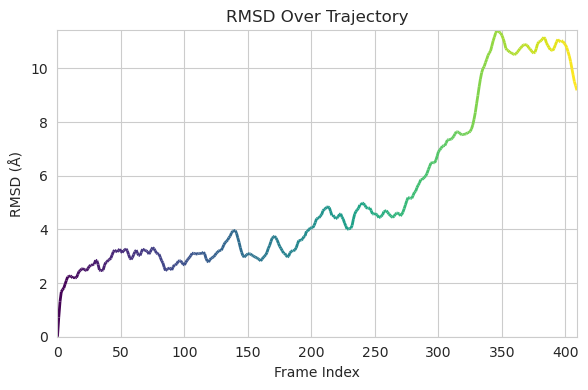

In [155]:
# Align all frames to the first frame
trace_traj.superpose(trace_traj[0])  # This removes rotation and translation

# Compute RMSD relative to the first frame
rmsd = mdtraj.rmsd(trace_traj, trace_traj, frame=0) * 10  # shape: (n_frames,)

# Prepare segments for gradient-colored line
x = np.arange(len(rmsd))
y = rmsd
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = np.linspace(0, 1, len(segments))

# Create LineCollection
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
lc.set_array(colors)
lc.set_linewidth(2)

# Create new figure for RMSD
fig_rmsd, ax_rmsd = plt.subplots(figsize=(6, 4))
ax_rmsd.add_collection(lc)
ax_rmsd.set_xlim(x.min(), x.max())
ax_rmsd.set_ylim(y.min(), y.max())
ax_rmsd.set_xlabel('Frame Index')
ax_rmsd.set_ylabel('RMSD (Å)')
ax_rmsd.set_title('RMSD Over Trajectory')

plt.tight_layout()
plt.show()